In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder


def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

# Import data
df = pd.read_csv('nhldraft.csv')

df.shape

(12250, 15)

In [2]:
df.head(5)

,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,games_played,goals,assists,points,plus_minus,penalties_minutes
0,2011,20,Phoenix Coyotes,Connor Murphy,US,D,18.0,2022.0,USA U-18 Development Team (USDP/USHL),551.0,32.0,88.0,120.0,-32.0,328.0
1,2012,81,Pittsburgh Penguins,Oskar Sundqvist,SE,C,18.0,2022.0,Skelleftea AIK Jr. (Sweden Jr.),288.0,40.0,55.0,95.0,-6.0,113.0
2,1985,169,Toronto Maple Leafs,Todd Whittemore,US,C,NaN,NaN,Kent School (High-CT),NaN,NaN,NaN,NaN,NaN,NaN
3,1986,108,New Jersey Devils,Troy Crowder,CA,RW,18.0,1997.0,Hamilton Steelhawks (OHL),150.0,9.0,7.0,16.0,-19.0,433.0
4,1999,70,Florida Panthers,Niklas Hagman,FI,LW,19.0,2012.0,HIFK (Finland),770.0,147.0,154.0,301.0,-40.0,220.0


In [3]:
# Need to give a value to all NaN

df.fillna(0, inplace = True)
df.head(5)

,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,games_played,goals,assists,points,plus_minus,penalties_minutes
0,2011,20,Phoenix Coyotes,Connor Murphy,US,D,18.0,2022.0,USA U-18 Development Team (USDP/USHL),551.0,32.0,88.0,120.0,-32.0,328.0
1,2012,81,Pittsburgh Penguins,Oskar Sundqvist,SE,C,18.0,2022.0,Skelleftea AIK Jr. (Sweden Jr.),288.0,40.0,55.0,95.0,-6.0,113.0
2,1985,169,Toronto Maple Leafs,Todd Whittemore,US,C,0.0,0.0,Kent School (High-CT),0.0,0.0,0.0,0.0,0.0,0.0
3,1986,108,New Jersey Devils,Troy Crowder,CA,RW,18.0,1997.0,Hamilton Steelhawks (OHL),150.0,9.0,7.0,16.0,-19.0,433.0
4,1999,70,Florida Panthers,Niklas Hagman,FI,LW,19.0,2012.0,HIFK (Finland),770.0,147.0,154.0,301.0,-40.0,220.0


In [4]:
# Getting position counts of all - paying attention to goalies (G)
df['position'].value_counts()

position
D        3966
C        2688
LW       2080
RW       2021
G        1217
C/LW       74
C/RW       49
W          44
0          27
LW/C       18
F          18
RW/C        8
LW/D        8
D/LW        6
C/D         5
D/RW        4
C/W         3
RW/D        3
C; LW       2
C / R       2
D/C         2
C RW        2
D/W         1
Centr       1
L/RW        1
Name: count, dtype: int64

In [5]:
# Remove goalies from data and simplify position terms
# In the original dataset they had their own stat for games played

# List for indices
indices_to_drop = []

for index, row in df.iterrows():
    # Check if goalie
    if row['position'] == 'G':
        # Mark index to drop
        indices_to_drop.append(index)
        
    if row['position'] == 'LW/C' or row['position'] == 'C; LW':
        df.replace(row['position'], 'C/LW', inplace=True)
        
    if row['position'] == 'LW/D':
        df.replace(row['position'], 'D/LW', inplace=True)
        
    if row['position'] == 'RW/C' or row['position'] == 'C / R' or \
       row['position'] == 'C RW':
        df.replace(row['position'], 'C/RW', inplace=True)
        
    if row['position'] == 'C/W' or row['position'] == 'L/RW' \
    or row['position'] == 'W':
        df.replace(row['position'], 'F', inplace=True)   
        
    if row['position'] == 'Centr':
        df.replace(row['position'], 'C', inplace=True)
        
    if row['position'] == 'C/D':
        df.replace(row['position'], 'D/C', inplace=True)
        
    if row['position'] == 'RW/D' or row['position'] == 'D/W':
        df.replace(row['position'], 'D/RW', inplace=True)    

# Remove marked indices
df.drop(indices_to_drop, inplace=True)

# Reset index of rows
df = df.reset_index(drop=True)

In [6]:
# No goalies now
df['position'].value_counts()

position
D       3966
C       2689
LW      2080
RW      2021
C/LW      94
F         66
C/RW      61
0         27
D/LW      14
D/RW       8
D/C        7
Name: count, dtype: int64

In [7]:
# Decreased size, because of goalies removed
df.shape

(11033, 15)

In [8]:
df.head(5)

,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,games_played,goals,assists,points,plus_minus,penalties_minutes
0,2011,20,Phoenix Coyotes,Connor Murphy,US,D,18.0,2022.0,USA U-18 Development Team (USDP/USHL),551.0,32.0,88.0,120.0,-32.0,328.0
1,2012,81,Pittsburgh Penguins,Oskar Sundqvist,SE,C,18.0,2022.0,Skelleftea AIK Jr. (Sweden Jr.),288.0,40.0,55.0,95.0,-6.0,113.0
2,1985,169,Toronto Maple Leafs,Todd Whittemore,US,C,0.0,0.0,Kent School (High-CT),0.0,0.0,0.0,0.0,0.0,0.0
3,1986,108,New Jersey Devils,Troy Crowder,CA,RW,18.0,1997.0,Hamilton Steelhawks (OHL),150.0,9.0,7.0,16.0,-19.0,433.0
4,1999,70,Florida Panthers,Niklas Hagman,FI,LW,19.0,2012.0,HIFK (Finland),770.0,147.0,154.0,301.0,-40.0,220.0


In [35]:
# Label encode all values
le = LabelEncoder()

# Get all rows with strings
teams = [df['team'][i] for i in range(len(df))]
players = [df['player'][i] for i in range(len(df))]
nationalities = [df['nationality'][i] for i in range(len(df))]
positions = [df['position'][i] for i in range(len(df))]
amateur_teams = [df['amateur_team'][i] for i in range(len(df))]

# Label encode each row
teams = le.fit_transform(teams)
players = le.fit_transform(players)
nationalities = le.fit_transform(nationalities)
positions = le.fit_transform(positions)
amateur_teams = le.fit_transform(amateur_teams)

# Show new row
nationalities

array([42, 34, 42, ..., 42,  8, 34])

In [10]:
# Replace each column

df['team'] = teams
df['player'] = players
df['nationality'] = nationalities
df['position'] = positions
df['amateur_team'] = amateur_teams

df.head(5)

,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,games_played,goals,assists,points,plus_minus,penalties_minutes
0,2011,20,32,2040,42,4,18.0,2022.0,1347,551.0,32.0,88.0,120.0,-32.0,328.0
1,2012,81,33,7762,34,1,18.0,2022.0,1141,288.0,40.0,55.0,95.0,-6.0,113.0
2,1985,169,39,10023,42,1,0.0,0.0,621,0.0,0.0,0.0,0.0,0.0,0.0
3,1986,108,26,10298,8,10,18.0,1997.0,525,150.0,9.0,7.0,16.0,-19.0,433.0
4,1999,70,18,7624,15,9,19.0,2012.0,481,770.0,147.0,154.0,301.0,-40.0,220.0


In [11]:
# Create X, removing games played

X = df.drop(columns=['games_played'])
X.head(10)

# Convert to numpy
X = X.to_numpy()

In [13]:
# Create y, with games played

df['games_played'].describe()

count    11033.000000
mean       137.152814
std        280.881682
min          0.000000
25%          0.000000
50%          0.000000
75%        101.000000
max       1779.000000
Name: games_played, dtype: float64

In [14]:
# Create y to be binary classification - 
# more or less games played than the mean
mean = 137
y = []
for new_y in range(len(df)):
    if df['games_played'][new_y] < mean:
        y.append(-1)
    else:
        y.append(1)

In [15]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 8826 2207


# Useful Functions

In [16]:
# The loss function measures how good our model is. The training goal is to minimize the loss.
# This is the logistic loss function.
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

# This is the gradient of the logistic loss
# The gradient is a vector that indicates the rate of change of the loss in each direction
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

def avg_grad(theta, X, y):
    grads = [gradient(theta, xi, yi) for xi, yi in zip(X, y)]
    return np.mean(grads, axis=0)

# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

# L2 Clipping
def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)
    
    if norm > b:
        return b * (v / norm)
    else:
        return v

def gradient_sum(theta, X, y, b):
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]
        
    # sum query
    # L2 sensitivity is b (by clipping performed above)
    return np.sum(gradients, axis=0)
    
# Noisy gradient descent
# Satisfies (k*epsilon + epsilon, k*delta)-differential privacy
def noisy_gradient_descent(iterations, epsilon, delta):
    theta = np.zeros(X_train.shape[1])
    b = 3

    
    noisy_count = laplace_mech(X_train.shape[0], 1, epsilon)

    for i in range(iterations):
        clipped_gradient_sum = gradient_sum(theta, X_train, y_train, b)
        noisy_gradient_sum = np.array(gaussian_mech_vec(clipped_gradient_sum, b, epsilon, delta))
        noisy_avg_gradient = noisy_gradient_sum / noisy_count
        theta = theta - noisy_avg_gradient

    return theta

# Baseline 
Use scikit-learn to train a logistic regression model on the training data loaded above.

In [17]:
def train_model():
    model = LogisticRegression().fit(X_train, y_train)
    return model

model = train_model()
#print('Model coefficients:', model.coef_[0])
print('Model accuracy:', np.sum(model.predict(X_test) == y_test)/X_test.shape[0])

Model accuracy: 0.9827820570910738


/Users/wyattchrisman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Noisy Gradient Descent RDP

A variant of noisy gradient descent that uses Rényi differential privacy. With a total privacy cost of $(\alpha, \bar\epsilon)$-RDP.

In [20]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

def noisy_gradient_descent_RDP(iterations, alpha, epsilon_bar):
    theta = np.zeros(X_train.shape[1])
    b = 3
    
    split_epsilon = epsilon_bar / (iterations + 1)
    
    noisy_count = laplace_mech(X_train.shape[0], 1, split_epsilon)

    for i in range(iterations):
        clipped_gradient_sum = gradient_sum(theta, X_train, y_train, b)
        noisy_gradient_sum = np.array(gaussian_mech_RDP_vec(clipped_gradient_sum, b, alpha, split_epsilon))
        noisy_avg_gradient = noisy_gradient_sum / noisy_count
        theta = theta - noisy_avg_gradient

    return theta


theta = noisy_gradient_descent_RDP(10, 20, 0.1)
print('Final accuracy:', accuracy(theta))

/var/folders/yf/m10_kkm12wg1sd18gc0mp32c0000gn/T/ipykernel_26453/3086723542.py:11: RuntimeWarning: overflow encountered in exp
  return - (yi*xi) / (1+np.exp(exponent))


Final accuracy: 0.784322609877662


## Noisy Gradient Descent zCDP
A variant of noisy gradient descent that uses zero-concentrated differential privacy. With a total privacy cost of $\rho$-zCDP.

In [21]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]


def noisy_gradient_descent_zCDP(iterations, rho):
    theta = np.zeros(X_train.shape[1])
    b = 3
    
    split_rho = rho / (iterations + 1)
    
    noisy_count = gaussian_mech_zCDP_vec([X_train.shape[0]], 1, split_rho)

    for i in range(iterations):
        clipped_gradient_sum = gradient_sum(theta, X_train, y_train, b)
        noisy_gradient_sum = np.array(gaussian_mech_zCDP_vec(clipped_gradient_sum, b, split_rho))
        noisy_avg_gradient = noisy_gradient_sum / noisy_count
        theta = theta - noisy_avg_gradient

    return theta

theta = noisy_gradient_descent_zCDP(10, 0.1)
print('Final accuracy:', accuracy(theta))

/var/folders/yf/m10_kkm12wg1sd18gc0mp32c0000gn/T/ipykernel_26453/3086723542.py:11: RuntimeWarning: overflow encountered in exp
  return - (yi*xi) / (1+np.exp(exponent))


Final accuracy: 0.784322609877662


## Results Graph
This is a graph of the accuracies depending on how many iterations are ran on each method. The data does take about 3 minutes to load because of the high iterations.

In [32]:
runs = 5

rdp10 = [accuracy(noisy_gradient_descent_RDP(10, 20, 0.1)) for _ in range(runs)]
rdp50 = [accuracy(noisy_gradient_descent_RDP(50, 20, 0.1)) for _ in range(runs)]
rdp100 = [accuracy(noisy_gradient_descent_RDP(100, 20, 0.1)) for _ in range(runs)]
rdp250 = [accuracy(noisy_gradient_descent_RDP(250, 20, 0.1)) for _ in range(runs)]

zcdp10 = [accuracy(noisy_gradient_descent_zCDP(10, 0.1)) for _ in range(runs)]
zcdp50 = [accuracy(noisy_gradient_descent_zCDP(50, 0.1)) for _ in range(runs)]
zcdp100 = [accuracy(noisy_gradient_descent_zCDP(100, 0.1)) for _ in range(runs)]
zcdp250 = [accuracy(noisy_gradient_descent_zCDP(250, 0.1)) for _ in range(runs)]


/var/folders/yf/m10_kkm12wg1sd18gc0mp32c0000gn/T/ipykernel_26453/3086723542.py:11: RuntimeWarning: overflow encountered in exp
  return - (yi*xi) / (1+np.exp(exponent))


In [23]:
# Get baseline data
scikit = []

model1 = train_model()
scikit.append(np.sum(model1.predict(X_test) == y_test)/X_test.shape[0])

model2 = train_model()
scikit.append(np.sum(model2.predict(X_test) == y_test)/X_test.shape[0])

model3 = train_model()
scikit.append(np.sum(model3.predict(X_test) == y_test)/X_test.shape[0])

model4 = train_model()
scikit.append(np.sum(model4.predict(X_test) == y_test)/X_test.shape[0])

/Users/wyattchrisman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wyattchrisman/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

In [33]:
# Get average accuracies

length = 5
avg_rdp10 = sum(rdp10)/length
avg_rdp50 = sum(rdp50)/length
avg_rdp100 = sum(rdp100)/length
avg_rdp250 = sum(rdp250)/length

rdp = [avg_rdp10, avg_rdp50, avg_rdp100, avg_rdp250]

avg_zcdp10 = sum(zcdp10)/length
avg_zcdp50 = sum(zcdp50)/length
avg_zcdp100 = sum(zcdp100)/length
avg_zcdp250 = sum(zcdp250)/length

zcdp = [avg_zcdp10, avg_zcdp50, avg_zcdp100, avg_zcdp250]


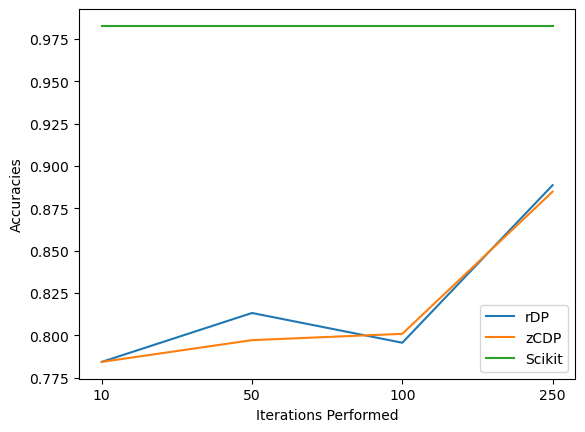

In [36]:
# Plot Data

iterations = ['10','50','100','250']
plt.ylabel('Accuracies')
plt.xlabel('Iterations Performed')


plt.plot(iterations, rdp, label = "rDP")
plt.plot(iterations, zcdp, label = "zCDP")
plt.plot(iterations, scikit, label = "Scikit")
plt.legend()
plt.show()